<div style="text-align: right"> 12/14/2018 </div> 
# Setting up parallelization of MCMC using emcee

Here, I go through the steps to figure out how to set up parallel MCMC in a minimal way. This will all be placed in a script to be run on a cluster, but for now is set up here for explanatory purposes. It directly follows on from 'debug-MCMC'.

First, import all the packages I am going to use.

In [5]:
import sys, os
sys.path.append("..")

from inverse import bayesian_funcs as bf
from inverse import priors as pr
from preprocess import preprocess as pp
from preprocess import permute
from brain import Brain
from utils import path as pth
from utils import functions

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
from scipy.io import loadmat
import numpy as np
from scipy.stats import pearsonr, gamma, uniform
import math
import pandas as pd
import emcee
import time 

## Finding a set of simulated annealing parameters 

For now we just want to pull out a set of parameters that we found in the debug notebook. These were the optimal simulated annealing parameters from Bobby's work for patient 8008.101.

In [6]:
param_start = [0.011934858833523522,
 0.007416371455534797,
 0.9670233044667013,
 14.479055812222878,
 3.9552727546221096,
 1.7950301129315296,
 0.008757838469754533]

## Get the corresponding MEG spectrum for this patient directly from its correctly ordered dictionary file


In [7]:
filename = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/freqMEGdata_8008_101.h5'

In [8]:
FMEGdownsample = pth.read_hdf5(filename)

In [9]:
#FMEGdownsample.keys()

## Set up an instance of the brain class, and the vector of frequencies for which the calculation is made.

In [10]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

(As a side note I am a bit concerned that the dictionary ordering has gone awry, so I'll be checking that elsewhere -- and will note here whether I think it is correct or not -- but for now I am ploughing on in the interests of not getting distracted by the boring stuff.)

## Set up the functions required for MCMC (I haven't incorporated them properly in to their modules yet.. this is just to show what they are and how they work)

In the final script obviously this will be dealt with elsewhere. 

First, the 'cost' function, here using the pearson r correlation. Alternative functions of this cost to be uesd in the likelihood calculation will be available as and when.

In [11]:
def pearson_cost(data, freq_model):
    """pearson_cost_oneminus. A cost function based on the pearson r correlation. Designed to
    be minimised in a fitting process. Uses '1-r' as a measure of data-model error.

    Args:
        data (dict): Data dictionary.
        freq_model (array): frequency model data in corresponding order

    Returns:
        floats: mean error based on pearson r, and a list of values over regions.

    """
    i = 0
    err_list = []
    for key in data.keys():
        modregion = freq_model[i,:]
        region = data[key]
        region = [float(x) for x in region]#we need to do this to make sure things are in the correct form for scipy.stats
        modregion = [float(x) for x in modregion]
        err = pearsonr(region,modregion)[0]
        err = 1 - err #to convert to an error to minimise.
        err_list.append(err)
        i += 1
    err = np.mean(sum(err_list))
    return err, err_list

Then we define a likelihood function defined around this form of the error. As it stands, maximising it will maximise the likelihood of the parameters, or the probability of the data given the parameters.

In [12]:
from forward import runforward as rf
def ln_likelihood_pearson(theta, brain, fvec, FMEGdata):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    #First need to convert parameter array to dictionary required by the run_forward func.
    if type(theta) != dict:
        parameters = {'tau_e':tau_e,
                       'tau_i':tau_i,
                       'alpha':alpha,
                       'speed':speed,
                       'gei':gei,
                       'gii':gii,
                       'tauC':tauC
                       }
    else:
        parameters = theta

    #first, run the ntf model for this setting of parameters
    freq_model = rf.run_forward(brain, parameters, fvec)

    #now calculate the pearson r based error
    errors, list_errors = pearson_cost(FMEGdata, freq_model)

    list_errors = np.asarray(list_errors)

    #calculate the total lnlikelihood based on the errors of the pearson cost function (this has to change depending on the precise form of the function, obvs)
    return -(np.sum(list_errors)) + 68*(1-np.log(math.e**2 - 1))

### Check the likelihood runs as expected. (Ignore if you are confident this is fine/just want to go for it)

In [13]:
tau_e, tau_i, alpha, speed, gei, gii, tauC = param_start
parameters = {'tau_e':tau_e,
                       'tau_i':tau_i,
                       'alpha':alpha,
                       'speed':speed,
                       'gei':gei,
                       'gii':gii,
                       'tauC':tauC
                       }

In [14]:
params = parameters #start with the set of parameters from simulated annealing, must be in dict form
taue_run = np.linspace(0.001, 0.2, 100)
trials = np.empty(len(taue_run)) 
for i in range(len(taue_run)):
    params['tau_e'] = taue_run[i]
    trials[i] = ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

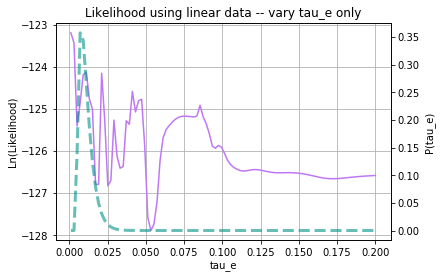

In [16]:
fig3, ax3a = mpl.subplots(figsize = (6,4))
mpl.plot(taue_run, trials, color = 'xkcd:light purple')

mpl.grid(True)
mpl.xlabel('tau_e')
mpl.ylabel('Ln(Likelihood)')
mpl.title('Likelihood using linear data -- vary tau_e only')
ax3b = ax3a.twinx()

fit_alpha_te = 2
fit_loc_te = 0.004492887509221829
fit_beta_te = 0.0032375996670863947
ytaue = (taue_run - fit_loc_te)/fit_beta_te
mpl.plot(taue_run, gamma.pdf(ytaue, fit_alpha_te),'--', lw=3, alpha=0.6, label='gamma pdf', color = 'xkcd:teal')
mpl.ylabel('P(tau_e)')

fig3.savefig("Patient_8008_101_Likelihood_tauevaryonly.pdf", bbox_inches='tight')

Looking at this I am slightly concerned that the prior distributions are too harsh, but that is another issue.

### Setting up prior distributions, using the fixed dictionary of distribution shape parameters

In [17]:
param_dists = {'tau_e':{'type':'gamma','alpha':2, 'loc':0.004492887509221829, 'scale':0.0032375996670863947},
              'tau_i':{'type':'gamma','alpha':2.006014687419703, 'loc':0.004662441067103153, 'scale':0.0025497764353055712},
              'alpha':{'type':'uniform','lower':0, 'upper':5},
              'speed':{'type':'uniform','lower':0, 'upper':25},
              'gei':{'type':'uniform','lower':0, 'upper':10},
              'gii':{'type':'uniform','lower':0, 'upper':10},
              'tauC':{'type':'gamma','alpha':2, 'loc':0.004211819821836749, 'scale':0.0029499360144432463}}

In [18]:
def lnprior_gamma(value, key, param_dists):
    tau = value
    x = (tau - param_dists[key]['loc'])/param_dists[key]['scale']
    p = gamma.pdf(x, param_dists[key]['alpha'])
    p = p.astype(float)
    if p == 0:
        return -np.inf #use the same as for outside uniform distribution bounds
    return math.log(p)

In [19]:
def lnprior_uniform(value, key, param_dists):
    if param_dists[key]['lower'] < value < param_dists[key]['upper']:
        p = uniform.pdf(value, loc = param_dists[key]['lower'], scale = param_dists[key]['upper'])
        return math.log(p)
    return -np.inf

In [20]:
def lnpriors(theta, param_dists):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    
    lnp_taue = lnprior_gamma(tau_e, 'tau_e', param_dists)
    lnp_taui = lnprior_gamma(tau_i, 'tau_i', param_dists)
    lnp_alpha = lnprior_uniform(alpha, 'alpha', param_dists)
    lnp_speed = lnprior_uniform(speed, 'speed', param_dists)
    lnp_gei = lnprior_uniform(gei, 'gei', param_dists)
    lnp_gii = lnprior_uniform(gii, 'gii', param_dists)
    lnp_tauC = lnprior_gamma(tauC, 'tauC', param_dists)
    
    return lnp_taue + lnp_taui + lnp_alpha+lnp_speed+lnp_gei+lnp_gii+lnp_tauC

### Set up the overall 'ln(posterior probability) distribution for all parameters' function

In [21]:
def lnprobs(theta, param_dists, brain, fvec, data):
    print(theta)
    lnprior = lnpriors(theta, param_dists)
    if not np.isfinite(lnprior):
        return -np.inf
    return lnprior + ln_likelihood_pearson(theta, brain, fvec, data)

## How to do basic MCMC run with no parallelization (ignore if you are wanting to try running in parallel)

First, set up your initial positions for each walker in the n-dimensional parameter space. Here I am deliberately setting up some of them to be off where they should be so we can hopefully see whether burn-in happens as it should.

We also need to tell emcee the number of walkers we want to use, and the dimension of the parameter space we are walking through.

In [22]:
ndim, nwalkers = 7, 16

In [23]:
param_start_2 = [0.2,
 0.2,
 0.9670233044667013,
 14.479055812222878,
 3.9552727546221096,
 1.7950301129315296,
 0.2]

pos = [np.transpose(param_start_2) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] #starting position in parameter space.

Initialise the sampler in the way we want it to be set up. We pass the walkers, dimensions, ln(probability) distribution function, and tell the sampler about the other fixed parameters that have to be passed to the function, including the instance of the brain class, the parameters of our prior distributions, the frequencies of calculation, and the data we are comparing to.

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobs, args=(param_dists, newbrain, fvec,FMEGdownsample))

At this point, we are ready to run the sampler. Hold on to your hats -- if you've set up a long run with lots of walkers, this could take a while. That's why we're going to parallelise it and make sure we can save as we go. (Comment this if you want -- it was just to check the code was working).

In [25]:
start = time.time()
sampler.run_mcmc(pos, 10);
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

[ 0.19992392  0.20005925  0.96720919 14.47897233  3.95535845  1.79500995
  0.19995004]
[ 0.20015553  0.19988628  0.96684016 14.47919648  3.95515245  1.79495418
  0.20003598]
[ 0.20001501  0.19996771  0.96702382 14.47898706  3.95518264  1.79509373
  0.19993276]
[ 0.19996387  0.20010002  0.96707496 14.47912488  3.95507587  1.7951411
  0.19992719]
[ 0.1999435   0.19977949  0.9669562  14.47899627  3.95532702  1.7950118
  0.19990725]
[ 0.19992959  0.20008768  0.96703393 14.47915871  3.95549582  1.79486214
  0.19995938]
[ 0.20003505  0.20009267  0.96703447 14.47890238  3.95525756  1.7950984
  0.20008956]
[ 0.19989109  0.19997954  0.96705363 14.47907683  3.95527615  1.79511142
  0.1999816 ]
[ 0.20012067  0.19998853  0.9670896  14.47909988  3.95521705  1.79514293
  0.19998714]
[ 0.20002947  0.19987893  0.96696586 14.47913589  3.95526017  1.79488591
  0.19994306]
[ 0.19992575  0.19985039  0.96694425 14.47896841  3.95525412  1.79502986
  0.20004367]
[ 0.20004604  0.19995576  0.96689301 14.479060

[ 0.19968591  0.19995867  0.96734873 14.48001033  3.95454922  1.79518936
  0.19924595]
[ 0.20042562  0.19912874  0.96615744 14.47863623  3.95557627  1.79460063
  0.19997864]
[ 0.19916434  0.19953425  0.96705535 14.48217227  3.95327107  1.79550519
  0.19756152]
[ 0.19997363  0.19957969  0.96701797 14.47865201  3.95590526  1.79485956
  0.19998644]
[ 0.20004799  0.2011383   0.96735481 14.47773989  3.95520772  1.79598757
  0.20090888]
[ 0.20030636  0.19987982  0.96686111 14.47885412  3.95514269  1.79457495
  0.19977908]
[ 0.19947843  0.20027926  0.96703295 14.47965699  3.95561328  1.79539667
  0.200634  ]
[ 0.19990074  0.20016592  0.96668801 14.47827961  3.95511249  1.79463359
  0.20002733]
[ 0.19969982  0.2003151   0.96769937 14.47927304  3.95525469  1.79507105
  0.19999223]
[ 0.19947404  0.20050884  0.96794725 14.47943838  3.95552943  1.79504676
  0.20007776]
[ 0.20053692  0.19981866  0.9663476  14.47875592  3.9549734   1.79475276
  0.20029734]
[ 0.19985083  0.19996745  0.96688105 14.479

Plot what you have.

In [ ]:
time = np.arange(1,10)
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:9,0], linewidth = 0.1, color = 'black')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_e')

With so few points it is difficult to make any sensible judgement about what that means. But maybe things will make sense and calm down after a while (before we saw that with only 16 walkers it took something like 80 steps).

# Trying out some parallel MCMC

First, following the advice here: https://emcee.readthedocs.io/en/latest/tutorials/parallel/
I am going to turn off potential automatic parallelization from NumPy (in case it is happening).

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
import emcee
print(emcee.__version__)

3.0rc2


Alright, we need to make sure we have the '3.0rc2' version of emcee. If you haven't got it, pip uninstall your old version of emcee, and reinstall from git using pip install git+git://github.com/dfm/emcee.git

Now, we just are going to try out the sample code from the emcee docs: https://emcee.readthedocs.io/en/latest/tutorials/parallel/

NOTE: this first example only deals with one machine, using multiple cores. To distribute on a cluster, you need to use the MPIPool from **schwimmbad** library (which you need to install first).

In [27]:
def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5*np.sum(theta**2)

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|██████████| 100/100 [00:21<00:00,  4.68it/s]

Serial took 21.4 seconds


In [28]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


Multiprocessing took 6.9 seconds
3.1 times faster than serial


In [29]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

4 CPUs


## How you would go about setting this up to run on a cluster

In this example from the emcee docs, it actually writes out a script (which you could just write elsewhere) and then executes it. 

In [39]:
with open("test_cluster_script.py", "w") as f:
    f.write("""
import sys
import time
import emcee
import numpy as np
from schwimmbad import MPIPool

def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5*np.sum(theta**2)

with MPIPool() as pool:
    if not pool.is_master():
        pool.wait()
        sys.exit(0)

    np.random.seed(42)
    initial = np.random.randn(32, 5)
    nwalkers, ndim = initial.shape
    nsteps = 100

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps)
    end = time.time()
    print(end - start)
""")

mpi_time = !mpiexec -n {ncpu} python test_cluster_script.py
mpi_time = float(mpi_time[0])
print("MPI took {0:.1f} seconds".format(mpi_time))
print("{0:.1f} times faster than serial".format(serial_time / mpi_time))

SyntaxError: invalid syntax (<ipython-input-39-a91da9052fe9>, line 33)

Alright, the only way we can really do this properly is on the cluster!